---

**Processing and Transformations Summary of "beers.csv"**

- **Renaming Columns**: "beer_id" to "bid", "beer_name" to "name"  
- **Converting Data Types**: "bid" to int and "abv", "ba_score", "bros_score" to float

---

**Descriptive Analysis Summary of "beers.csv"**
* **Missing values**: No beers have missing bid

<br>

* **general**
  - There are 230,141 beers after processing
  - The beers pipeline conserves a majority of the beers (81.95%)
  - The avg_rating range is [1, 5]
  - Beers have $\approx$ 33 ratings on average, with a large std of $\approx$ 232. 
  - Beers have $\approx$ 10 reviews on average (about 3x smaller than average number of ratings) with a large std of $\approx$ 71
  - ba_score and bros_score range is [0, 100] (although the smallest ba_score and bro score is higher than 0)
  
<br>

* **ba and bros score**
  - 26.56% of the beers have a BA score
  - 2.48% of the beers have a bros score
  - 26.84% have a bros score or BA score
  - 94.29% of the ratings are for beers with a BA or bros score
  - mean number of ratings for beers is $\approx$ 33 in general, but $\approx$ 117 for beers having a BA or bros score
  - BA score follows a gaussian concentrated between $\approx$ 80 and $\approx$ 90
  - bros score are more sparse, but also averaging around $\approx$ 80 and $\approx$ 90

<br>

* **n_reviews** 
  - 66.99% of the beers have at least 1 review
  - the number of reviews per beer is heavy-tailed, where the 25% quantile is 3 reviews and the 75% quantile is 19 ratings, while there are some beers with a lot of ratings(max is 3695)

<br>

* **n_ratings**
  - 100% of the beers have at least 1 rating
  - the number of ratings per beer is heavy-tailed (very similar to the number of reviews), where the 25% quantile 1 rating and 50% quantile is 3 ratings, while there are some beers with a lot of ratings (max is 15065) 
  
<br>

* **avg_rating**
  - the average rating follows a gaussian concentrated between $\approx$ 3 and $\approx$ 4.5



In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# setup

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

# [I] Loading the Data

In [3]:
beers_parquet_path = "RefinedData/BeerAdvocate/beers.parquet/"

In [4]:
users_ddf = prc.users_pipeline(persist=True)
ratings_ddf = prc.ratings_pipeline(persist=True, users_persisted=True)
beerscsv_ddf = prc.beerscsv_pipeline(persist=True)


In [5]:
beers_ddf = prc.beers_pipeline(persist=True, ratings_persisted=True, beerscsv_persisted=True)
beers_ddf.head(5)

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


In [6]:
beers_ddf = pd.read_parquet(beers_parquet_path)
beers_ddf.head(5)

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
__null_dask_index__,,,,,,,,,,
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


In [7]:
__BEERS_CSV_COLS_OF_INTEREST = [
    "beer_id",
    "beer_name",
    "style",
    "abv",
    "ba_score",
    "bros_score"]
    
# raw data for beers.csv
beerscsv_ddf = ing.read_csv(
    path=ing.build_path(folderind="ba", filename="beers", ext=".csv"),
    keepcols=__BEERS_CSV_COLS_OF_INTEREST,
    mode="lazy")
beerscsv_ddf.head(5)

,beer_id,beer_name,style,ba_score,bros_score,abv
0,166064,Nashe Moskovskoe,Euro Pale Lager,NaN,NaN,4.7
1,166065,Nashe Pivovskoe,Euro Pale Lager,NaN,NaN,3.8
2,166066,Nashe Shakhterskoe,Euro Pale Lager,NaN,NaN,4.8
3,166067,Nashe Zhigulevskoe,Euro Pale Lager,NaN,NaN,4.0
4,166063,Zhivoe,Euro Pale Lager,NaN,NaN,4.5


# [II] beers.csv pipeline analysis

In [8]:
n_beers = beerscsv_ddf.shape[0].compute()
print("Number of beers in beers.csv before the processing: {}".format(n_beers))

Number of beers in beers.csv before the processing: 280823


In [9]:
# drop beers with unknown beer BID
beerscsv_ddf = beerscsv_ddf[beerscsv_ddf["beer_id"].notnull()]

n_beers_known_bid = beerscsv_ddf.shape[0].compute()
print("Number of beers in beers.csv after dropping beers with uknown BID: {}".format(n_beers_known_bid))

Number of beers in beers.csv after dropping beers with uknown BID: 280823


# [III] Descriptive Statistics & Distributions

In [10]:
beers_ddf.describe()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,abv
count,230141.000000,230141.000000,230141.000000,230141.000000,230141.000000,61121.000000,5702.000000,200427.000000
mean,142103.769024,33.261757,3.738507,10.493085,0.370488,84.635147,84.806557,6.578397
std,83920.400725,232.124256,0.447232,71.466069,0.377600,4.054117,10.507727,2.074679
min,3.000000,1.000000,1.000000,0.000000,0.000000,46.000000,31.000000,0.010000
25%,71209.000000,1.000000,3.524000,0.000000,0.000000,83.000000,81.000000,5.000000
50%,135960.000000,3.000000,3.786250,1.000000,0.250000,85.000000,87.000000,6.000000
75%,215315.000000,9.000000,4.008000,3.000000,0.666667,86.000000,91.000000,7.600000
max,293296.000000,15065.000000,5.000000,3695.000000,1.000000,100.000000,100.000000,67.500000


## ba_score and bros_score

In [11]:
print("How many beers there are after processing and what is the percentage that was kept compared to the raw data?")
print("{} ({}%)".format(beers_ddf.shape[0], round(beers_ddf.shape[0]/n_beers*100, 2)))

How many beers there are after processing and what is the percentage that was kept compared to the raw data?
230141 (81.95%)


In [13]:
print("How many beers have a BA score ?")
beers_ba = beers_ddf[beers_ddf.ba_score.notnull()]
print("{} ({}%)".format(beers_ba.shape[0], round(beers_ba.shape[0]/beers_ddf.shape[0]*100, 2)))

How many beers have a BA score ?
61121 (26.56%)


In [14]:
print("How many beers have a Bros score ?")
beers_bro = beers_ddf[beers_ddf.bros_score.notnull()]
print("{} ({}%)".format(beers_bro.shape[0], round(beers_bro.shape[0]/beers_ddf.shape[0]*100, 2)))

How many beers have a Bros score ?
5702 (2.48%)


In [15]:
print("How many beers have a BA score and a Bros score ?")
beers_ba_bro = beers_ddf[(beers_ddf.ba_score.notnull()) & (beers_ddf.bros_score.notnull())]
print("{} ({}%)".format(beers_ba_bro.shape[0], round(beers_ba_bro.shape[0]/beers_ddf.shape[0]*100, 2)))

How many beers have a BA score and a Bros score ?
5047 (2.19%)


In [16]:
print("How many beers have a BA score or a Bros score ?")
beers_ba_bro = beers_ddf[(beers_ddf.ba_score.notnull()) | (beers_ddf.bros_score.notnull())]
print("{} ({}%)".format(beers_ba_bro.shape[0], round(beers_ba_bro.shape[0]/beers_ddf.shape[0]*100, 2)))

How many beers have a BA score or a Bros score ?
61776 (26.84%)


In [17]:
print("How many ratings there are for beers with a BA or Bros score ?")
beers_ba_bros_ddf = beers_ddf[(beers_ddf.ba_score.notnull()) | (beers_ddf.bros_score.notnull())]
beers_ba_bros_ddf["n_ratings"].sum()


How many ratings there are for beers with a BA or Bros score ?


7217545

In [18]:
beers_ba_bros_ddf.describe()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,abv
count,61776.000000,61776.000000,61776.000000,61776.000000,61776.000000,61121.000000,5702.000000,57767.000000
mean,106447.352888,116.834127,3.785208,36.600363,0.326899,84.635147,84.806557,6.904777
std,73208.910932,437.236255,0.385004,134.506283,0.239612,4.054117,10.507727,2.269834
min,3.000000,1.000000,1.140000,0.000000,0.000000,46.000000,31.000000,0.050000
25%,50143.000000,13.000000,3.597000,3.000000,0.153846,83.000000,81.000000,5.200000
50%,93843.500000,24.000000,3.820000,7.000000,0.258065,85.000000,87.000000,6.500000
75%,153272.250000,65.000000,4.031284,19.000000,0.444444,86.000000,91.000000,8.000000
max,292783.000000,15065.000000,4.875312,3695.000000,1.000000,100.000000,100.000000,65.000000


We see that beers with a ba or bros score have 10x more ratings on average compared to beers in general

In [19]:
print("What is the ratio of number of beers with a BA score or Bros score to the total number of beers ?")
print("{}%".format(round(beers_ba_bros_ddf.shape[0] / beers_ddf.shape[0] * 100, 2)))

What is the ratio of number of beers with a BA score or Bros score to the total number of beers ?
26.84%


In [20]:
print("What is the ratio of number of ratings for beers with a BA or Bros score to the total number of ratings ?")
print("{}%".format(round(beers_ba_bros_ddf["n_ratings"].sum() / beers_ddf["n_ratings"].sum() * 100, 2)))

What is the ratio of number of ratings for beers with a BA or Bros score to the total number of ratings ?
94.29%


<AxesSubplot:title={'center':'Distribution of the BA score'}, xlabel='BA score', ylabel='Number of beers'>

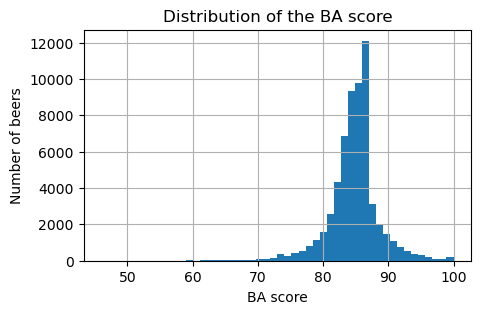

In [21]:
# show the distribution of the BA score
# set the figure size
plt.figure(figsize=(5, 3))

# set x and y axis labels
plt.xlabel("BA score")
plt.ylabel("Number of beers")

# set the title
plt.title("Distribution of the BA score")

# plot the histogram
beers_ba_bros_ddf["ba_score"].hist(bins=50)

<AxesSubplot:title={'center':'Distribution of the Bros score'}, xlabel='Bros score', ylabel='Number of beers'>

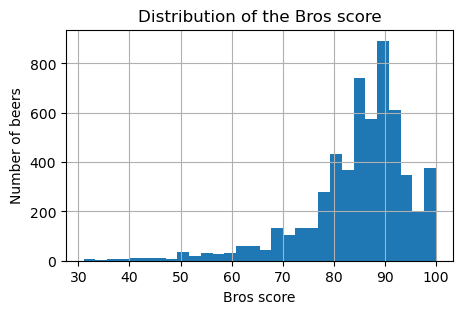

In [22]:
# show the distribution of the Bros score
# set the figure size
plt.figure(figsize=(5, 3))

# set x and y axis labels
plt.xlabel("Bros score")
plt.ylabel("Number of beers")

# set the title
plt.title("Distribution of the Bros score")

# plot the histogram
beers_ba_bros_ddf["bros_score"].hist(bins=30)

## n_reviews

In [23]:
print("What percentage of beers have at least one review ?")
print("{}%".format(round(beers_ddf[beers_ddf["n_reviews"] > 0].shape[0] / beers_ddf.shape[0] * 100, 2)))

What percentage of beers have at least one review ?
66.99%


<AxesSubplot:title={'center':'Distribution of the number of reviews'}, xlabel='Number of reviews', ylabel='Number of beers'>

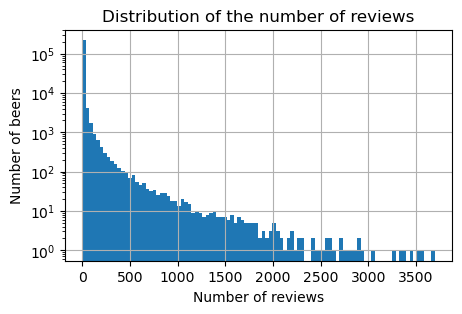

In [24]:
# show the distribution of the number of reviews
# set the figure size
plt.figure(figsize=(5, 3))

# set x and y axis labels
plt.xlabel("Number of reviews")
plt.ylabel("Number of beers")

# set the title
plt.title("Distribution of the number of reviews")

# plot the histogram
beers_ddf["n_reviews"].hist(log=True,bins=100)

## n_ratings

In [25]:
print("What percentage of the beers have at least 1 rating ?")
print("{}%".format(round(beers_ddf[beers_ddf["n_ratings"] > 0].shape[0] / beers_ddf.shape[0] * 100, 2)))

What percentage of the beers have at least 1 rating ?
100.0%


<AxesSubplot:title={'center':'Distribution of the number of ratings per beer'}, xlabel='Number of ratings per beer', ylabel='Number of beers'>

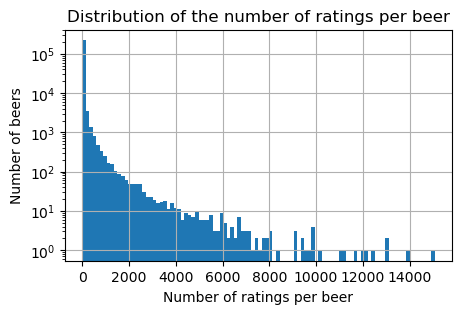

In [26]:
# show the distribution of the number of ratings per beer in log scale
# set the figure size
plt.figure(figsize=(5, 3))

# set x and y axis labels
plt.xlabel("Number of ratings per beer")
plt.ylabel("Number of beers")

# set the title
plt.title("Distribution of the number of ratings per beer")

# plot the histogram
beers_ddf["n_ratings"].hist(bins=100, log=True)

## avg_rating

<AxesSubplot:title={'center':'Distribution of the average rating of a beer'}, xlabel='Average rating of a beer', ylabel='Number of beers'>

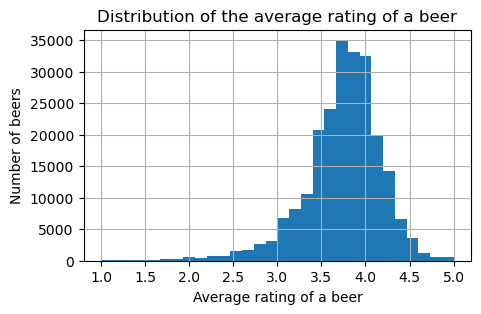

In [27]:
# show the distribution of the average rating per beer
# set the figure size
plt.figure(figsize=(5, 3))

# set x and y axis labels
plt.xlabel("Average rating of a beer")
plt.ylabel("Number of beers")

# set the title
plt.title("Distribution of the average rating of a beer")

# plot the histogram
beers_ddf["avg_rating"].hist(bins=30)



In [28]:
dask_shutdown(client)

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
